In [1]:
import os
os.chdir("..")

In [2]:
import sys
path_to_repo = os.path.abspath(".") + '/other_repos/Conditional_Density_Estimation/'

if path_to_repo not in sys.path:
    sys.path.insert(0, path_to_repo)


from cde.density_simulation import GaussianMixture

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.preprocessing import StandardScaler

import pandas as pd

import pickle

import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor

from tqdm import tqdm

# Notebook Params

In [4]:
with_existing_data = False

save_path = "datasets/simulated_data/"
distribution_file = "gmm.pkl"
distribution_file_path = save_path + distribution_file
samples_file_naming = "gmm_samples"


save_to_disk = True
n_train_samples = 100000
n_test_samples = int(0.05 * n_train_samples)
n_val_samples = int(0.05 * n_train_samples)

# Create Distribution Function

In [5]:
if not with_existing_data:
    density_simulator = GaussianMixture(n_kernels=10, ndim_x=2, ndim_y=1, means_std=1.5, random_seed=22)

    if save_path and save_to_disk:
        os.makedirs(save_path, exist_ok=True)
        if distribution_file_path:
            with open(distribution_file_path, 'wb') as file:
                pickle.dump(density_simulator, file)

In [6]:
if with_existing_data:
    with open(distribution_file, 'rb') as file:
        density_simulator = pickle.load(file)

### Create Synthetic Dataset

In [7]:
if not with_existing_data:
    samples_x_train, samples_y_train = density_simulator.simulate(n_samples = n_train_samples)
    samples_x_train, samples_y_train = samples_x_train.astype(np.float32), samples_y_train.astype(np.float32)

    samples_x_test, samples_y_test = density_simulator.simulate(n_samples = n_test_samples)
    samples_x_test, samples_y_test = samples_x_test.astype(np.float32), samples_y_test.astype(np.float32)

    samples_x_val, samples_y_val = density_simulator.simulate(n_samples = n_val_samples)
    samples_x_val, samples_y_val = samples_x_val.astype(np.float32), samples_y_val.astype(np.float32)


    if save_path and samples_file_naming:
        np.savetxt(save_path + samples_file_naming + "_x_train.csv", samples_x_train, delimiter=",")
        np.savetxt(save_path + samples_file_naming + "_y_train.csv", samples_y_train, delimiter=",")
        np.savetxt(save_path + samples_file_naming + "_x_test.csv", samples_x_test, delimiter=",")
        np.savetxt(save_path + samples_file_naming + "_y_test.csv", samples_y_test, delimiter=",")
        np.savetxt(save_path + samples_file_naming + "_x_val.csv", samples_x_val, delimiter=",")
        np.savetxt(save_path + samples_file_naming + "_y_val.csv", samples_y_val, delimiter=",")

In [8]:
if with_existing_data:
    samples_x_train = np.loadtxt(save_path + samples_file_naming + "_x_train.csv", delimiter=",")
    samples_y_train = np.loadtxt(save_path + samples_file_naming + "_y_train.csv", delimiter=",")
    samples_x_test = np.loadtxt(save_path + samples_file_naming + "_x_test.csv", delimiter=",")
    samples_y_test = np.loadtxt(save_path + samples_file_naming + "_y_test.csv", delimiter=",")
    samples_x_val = np.loadtxt(save_path + samples_file_naming + "_x_val.csv", delimiter=",")
    samples_y_val = np.loadtxt(save_path + samples_file_naming + "_y_val.csv", delimiter=",")

# Define Models

In [9]:
class MLP(nn.Module):

    def __init__(self, n_input: int, n_hidden: list, n_output: int, dropout_rate: float = 0.1, activation_function: nn.Module = nn.ReLU(), **kwargs):
        """
        Initializes the MLP.

        Parameters:
        -----------
        n_input : int
            Number of input features.
        n_hidden : list of int
            List containing the number of neurons in each hidden layer.
        n_output : int
            Number of output features.
        dropout_rate : float
            Dropout rate to be used in dropout layers.
        activation_function : nn.Module
            Activation function to be used in hidden layers.
        """
        super(MLP, self).__init__()

        self.dropout = nn.Dropout(p=dropout_rate)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_input, n_hidden[0])])
        self.hidden_layers.extend([nn.Linear(n_hidden[i], n_hidden[i+1]) for i in range(len(n_hidden)-1)])
        self.output_layer = nn.Linear(n_hidden[-1], n_output)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor to the network.

        Returns:
        --------
        torch.Tensor
            Output tensor of the network after passing through all layers.
        """
        x = self.dropout(x)
        for hidden_layer in self.hidden_layers:
            x = self.activation_function(hidden_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

class MDN(nn.Module):
    def __init__(self, n_inputs:int, n_hidden:list, n_distributions:int, dropout_rate:float = 0.2, activation_function:nn.Module = nn.ReLU(), distribution_type = "gaussian", scaler_x=None, scaler_y=None, **kwargs):
        super().__init__()

        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
        self.distribution_type = distribution_type
        self.n_distributions = n_distributions
        self.mlp = MLP(n_inputs, n_hidden,n_distributions*3, dropout_rate,activation_function, **kwargs)


    def forward(self, x):
        
        if self.scaler_x:
            x = (x - self.scaler_x[0]) / self.scaler_x[1]
        mlp_out = self.mlp(x)
        logits, mu, log_sigma = torch.split(mlp_out, self.n_distributions, dim=1)
        
        sigma = torch.exp(log_sigma)
        weights = F.softmax(logits, dim=1)

        if self.scaler_y:
            mu = self.scaler_y[1] * mu + self.scaler_y[0]
            sigma = self.scaler_y[1] * sigma
            
        return weights, mu, sigma

In [19]:
def mdn_loss_fn(y, weights, mu, sigma, reduce="mean"):
    distribution = torch.distributions.Normal(mu, sigma)
    loss = torch.exp(distribution.log_prob(y))
    loss = torch.sum(loss * weights, dim=1)
    loss = -torch.log(loss)
    if reduce == "mean":
        loss = torch.mean(loss)
    elif reduce == "sum":
        loss = torch.sum(loss)
    return loss

def hellinger_distance(distribution, x, weights, mu, sigma, reduce="mean"):

    if not isinstance(x, np.ndarray):
        x = x.detach().cpu().numpy()
    if not isinstance(weights, np.ndarray):
        weights = weights.detach().cpu().numpy()
    if not isinstance(mu, np.ndarray):
        mu = mu.detach().cpu().numpy()
    if not isinstance(sigma, np.ndarray):
        sigma = sigma.detach().cpu().numpy()

    linspace = np.linspace(-10, 10, 100)  # Adjust range as necessary
    y_space = np.reshape(linspace, (-1, 1))

    hellinger_distances = []

    for idx in range(weights.shape[0]):
        
        # Calculate true density
        x_space = np.repeat(np.reshape(x[idx], (1,-1)), y_space.shape[0], axis=0)
        true_densities = distribution.pdf(x_space, y_space)  # True density

        # Calculate estimated density
        dist = torch.distributions.Normal(torch.from_numpy(mu[idx]), torch.from_numpy(sigma[idx]))
        estimated_densities = torch.exp(dist.log_prob(torch.from_numpy(y_space)))
        estimated_densities = torch.sum(estimated_densities * torch.from_numpy(weights[idx]), dim=1)
        
        # Calculate Hellinger distance component wise
        # sqrt(p(x)) - sqrt(q(x)) and then square
        diff_sq = (torch.sqrt(torch.tensor(true_densities, dtype=torch.float32)) - torch.sqrt(estimated_densities))**2
        h_distance = torch.sqrt(torch.sum(diff_sq) / 2)  # Integrate and multiply by 1/sqrt(2)
        
        hellinger_distances.append(h_distance.item())
    
    if reduce == "mean":
        hellinger_distances = np.mean(hellinger_distances)
    elif reduce == "sum":
        hellinger_distances = np.sum(hellinger_distances)

    return hellinger_distances

def reliabiltiy_loss_fn(y: Tensor, weights: Tensor, mu: Tensor, sigma: Tensor, n_samples: int = 100):
    device = y.device

    distribution = torch.distributions.Normal(mu, sigma)
    drawn_samples = distribution.sample((n_samples,)).transpose(0,1)
    component_indices = torch.multinomial(weights, n_samples, replacement=True)
    effective_samples = torch.gather(drawn_samples, -1, component_indices.unsqueeze(-1)).squeeze(-1)
    y = y.squeeze(-1)
    
    quantiles = torch.arange(5, 96, 10, device=device)/100

    upper_bounds = torch.quantile(effective_samples, quantiles, dim=-1)
    y_r = (y < upper_bounds).sum(dim=-1) / y.shape[0]

    reliability_loss = (y_r - quantiles).abs().mean() #maybe use trapz shomehow instead of mean

    return reliability_loss


def evaluate_model(model, val_loader, device, distribution = None):
    model.eval()
    val_loss = 0
    hellinger_dist = 0
    reliability_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            weights, mu, sigma = model(x)
            if distribution:
                hellinger_dist += hellinger_distance(distribution, x, weights, mu, sigma, reduce="sum")
            val_loss += mdn_loss_fn(y, weights, mu, sigma, reduce="sum").item()
            reliability_loss += reliabiltiy_loss_fn(y, weights, mu, sigma) * y.shape[0]
    val_loss /= len(val_loader.dataset)
    hellinger_dist /= len(val_loader.dataset)
    reliability_loss /= len(val_loader.dataset)

    return_dict = {"val_loss" : val_loss, "reliability_loss":reliability_loss}
    if distribution:
        return_dict["hellinger_dist"] = hellinger_dist
    return return_dict

def train_model(model, optimizer, train_loader, val_loader, epochs, device, input_noise_x = 0.0, input_noise_y = 0.0, distribution = None):
    model.train()
    bar = tqdm(range(epochs))
    for epoch in bar:
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            
            if input_noise_x > 0.0:
                x = x + torch.randn_like(x) * input_noise_x
            if input_noise_y > 0.0:
                y = y + torch.randn_like(y) * input_noise_y

            optimizer.zero_grad()
            weights, mu, sigma = model(x)
            loss = mdn_loss_fn(y, weights, mu, sigma)
            reliabiltiy_loss = reliabiltiy_loss_fn(y, weights, mu, sigma)

            loss = loss + reliabiltiy_loss * 50
            loss.backward()
            optimizer.step()
                
        val_loss = evaluate_model(model, val_loader, device, distribution)
        if distribution:
            bar.set_description("Epoch: {:d}, Val Loss: {:.4f}, Hellinger Dist: {:.4f}, Reliability Loss: {:.4f}".format(epoch, val_loss["val_loss"], val_loss["hellinger_dist"], val_loss["reliability_loss"]))
        else:
            bar.set_description("Epoch: {:d}, Val Loss: {:.4f}, Reliability Loss: {:.4f}".format(epoch, val_loss["val_loss"], val_loss["reliability_loss"]))

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mu_x, sigma_x = np.mean(samples_x_train, axis=0), np.std(samples_x_train, axis=0)
mu_y, sigma_y = np.mean(samples_y_train, axis=0), np.std(samples_y_train, axis=0)
mu_x, sigma_x = torch.tensor(mu_x, device=device), torch.tensor(sigma_x, device=device)
mu_y, sigma_y = torch.tensor(mu_y, device=device), torch.tensor(sigma_y, device=device)

model = MDN(n_inputs=2, n_hidden=[32,32], n_distributions=10, dropout_rate=0.1, scaler_x = (mu_x, sigma_x), scaler_y = (mu_y, sigma_y), activation_function=nn.ReLU())
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_loader = torch.utils.data.DataLoader(list(zip(samples_x_train, samples_y_train)), batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(samples_x_val, samples_y_val)), batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(list(zip(samples_x_test, samples_y_test)), batch_size=128, shuffle=False)



train_model(model, optimizer, train_loader, val_loader, 50,  input_noise_x = 0.1, input_noise_y=0.1, device=device, distribution=density_simulator)

Epoch: 49, Val Loss: 1.9314, Hellinger Dist: 0.0796, Reliability Loss: 0.0238: 100%|██████████| 50/50 [09:12<00:00, 11.04s/it]


### Visualize Predicted Distributions vs. actual distributions

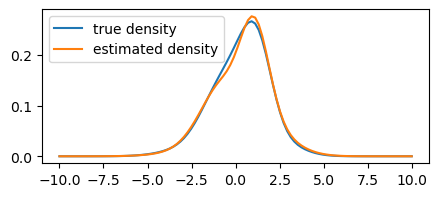

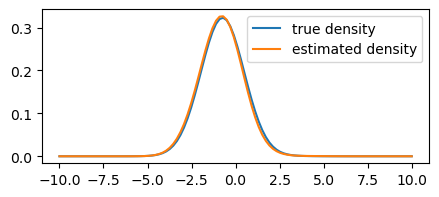

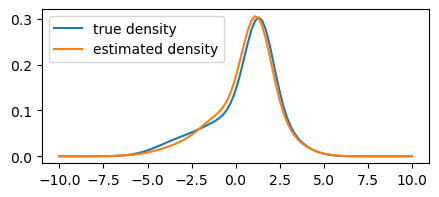

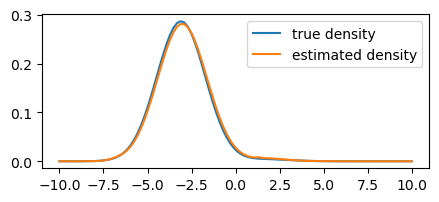

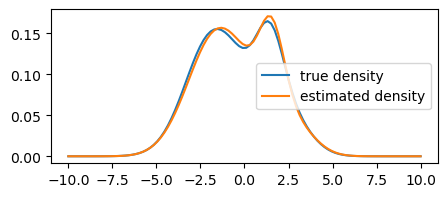

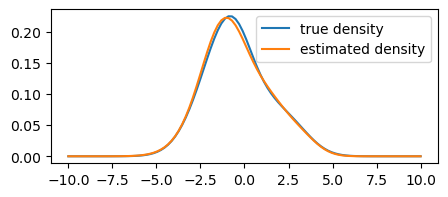

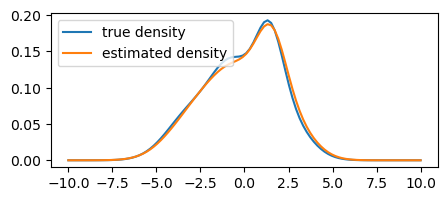

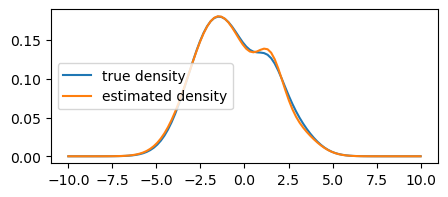

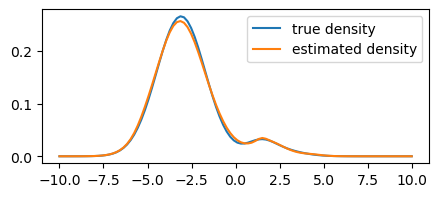

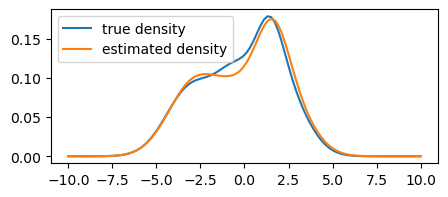

In [21]:
linspace = np.linspace(-10, 10, 100)
y_space = np.reshape(linspace, (-1, 1))
n_samples = 10

for idx,x in enumerate(samples_x_test[np.random.choice(samples_x_test.shape[0], n_samples)]):
    plt.figure(figsize=(5,2))

    x_space = np.repeat(np.reshape(x, (1,-1)), 100, axis=0)
    densities = density_simulator.pdf(x_space, y_space)

    plt.plot(linspace, densities, label="true density")

    x = torch.from_numpy(x).to(device)
    x = x.unsqueeze(0)

    weights, mu, sigma = model(x)
    weights = weights.detach().cpu()
    mu = mu.detach().cpu()
    sigma = sigma.detach().cpu()

    dist = torch.distributions.Normal(mu, sigma)
    densities = torch.exp(dist.log_prob(torch.from_numpy(y_space)))
    densities = torch.sum(densities * weights, dim=1)

    plt.plot(linspace, densities, label="estimated density")
    plt.legend()
    plt.show()

In [22]:
n_samples = 100
linspace = np.linspace(-10, 10, 100)  # Adjust range as necessary
y_space = np.reshape(linspace, (-1, 1))

hellinger_distances = []

for idx, x in enumerate(samples_x_test):
    
    # Calculate true density
    x_space = np.repeat(np.reshape(x, (1,-1)), 100, axis=0)
    true_densities = density_simulator.pdf(x_space, y_space)  # True density

    # Calculate estimated density
    x = torch.from_numpy(x).to(device)
    x = x.unsqueeze(0)
    weights, mu, sigma = model(x)
    dist = torch.distributions.Normal(mu.detach().cpu(), sigma.detach().cpu())
    estimated_densities = torch.exp(dist.log_prob(torch.from_numpy(y_space)))
    estimated_densities = torch.sum(estimated_densities * weights.detach().cpu(), dim=1)
    
    # Calculate Hellinger distance component wise
    # sqrt(p(x)) - sqrt(q(x)) and then square
    diff_sq = (torch.sqrt(torch.tensor(true_densities, dtype=torch.float32)) - torch.sqrt(estimated_densities))**2
    h_distance = torch.sqrt(torch.sum(diff_sq) / 2)  # Integrate and multiply by 1/sqrt(2)
    
    hellinger_distances.append(h_distance.item())

# Average Hellinger distance for the sampled x values, or you might use them individually
average_hellinger_distance = sum(hellinger_distances) / len(hellinger_distances)
print("Average Hellinger Distance: ", average_hellinger_distance)


Average Hellinger Distance:  0.08142167448313067


## Reliability Plots

In [23]:
def sample_mixture_of_gaussians(weights, means, stds, n_samples):
    n_components = len(weights)
    component_indices = torch.multinomial(weights, n_samples, replacement=True)
    samples = torch.zeros(n_samples)
    
    for i in range(n_components):
        # Indices where this component is chosen
        component_mask = component_indices == i
        
        # Number of times this component is chosen
        n_component_samples = component_mask.sum()
        
        # Sample from the Gaussian component
        if n_component_samples > 0:
            samples[component_mask] = torch.normal(means[i].item(), stds[i].item(), size= (n_component_samples.item(),))
    
    return samples

In [24]:
def uncertainty_plot(y: np.ndarray, y_hat: np.ndarray, title: str = '') -> tuple:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))


    # Probability plot:
    y_long = y[:, -1].flatten()
    y_hat_long = y_hat[:, -1, :].reshape(y_long.shape[0], -1)
    x_bnd = np.arange(0, min(400, y.shape[0]))
    y_bnd_len = len(x_bnd)

    quantiles = np.arange(0, 101, 5)
    y_r = np.zeros(len(quantiles))
    for idx, ub in enumerate(quantiles):
        #in the assymetric case we only look at the upper bound always
        y_ub = np.percentile(y_hat_long[x_bnd, :], ub, axis=-1).flatten()
        y_r[idx] = np.sum(y_long[x_bnd] < y_ub) / y_bnd_len

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(quantiles / 100, y_r, '-.', ms=3.0)

    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_xlabel("Theoretical quantile frequency")
    ax.set_ylabel("Count")
    ax.set_title(title)

    return fig, ax

def uncertainty_plot_centered(y: np.ndarray, y_hat: np.ndarray, title: str = '') -> tuple:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))


    # Probability plot:
    y_long = y[:, -1].flatten()
    y_hat_long = y_hat[:, -1, :].reshape(y_long.shape[0], -1)
    x_bnd = np.arange(0, min(400, y.shape[0]))
    y_bnd_len = len(x_bnd)

    quantiles = np.arange(0, 101, 5)
    y_r = np.zeros(len(quantiles))
    for idx in range(len(quantiles)):
        # In the symmetric case, we look at both bounds. We basically start from the middle and go outwards
        lb = round(50 - (quantiles[idx]) / 2)
        ub = round(50 + (quantiles[idx]) / 2)
        y_lb = np.percentile(y_hat_long[x_bnd, :], lb, axis=-1).flatten()
        y_ub = np.percentile(y_hat_long[x_bnd, :], ub, axis=-1).flatten()
        y_r[idx] = np.sum(((y_long[x_bnd] > y_lb) * (y_long[x_bnd] < y_ub))) / y_bnd_len

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(quantiles / 100, y_r, '-.', ms=3.0)

    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_xlabel("Theoretical quantile frequency")
    ax.set_ylabel("Count")
    ax.set_title(title)

    return fig, ax

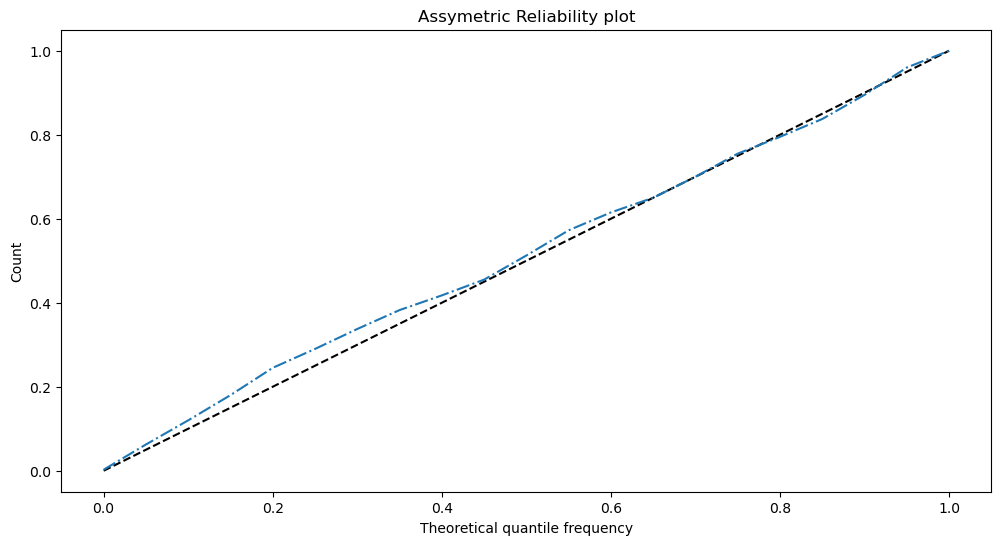

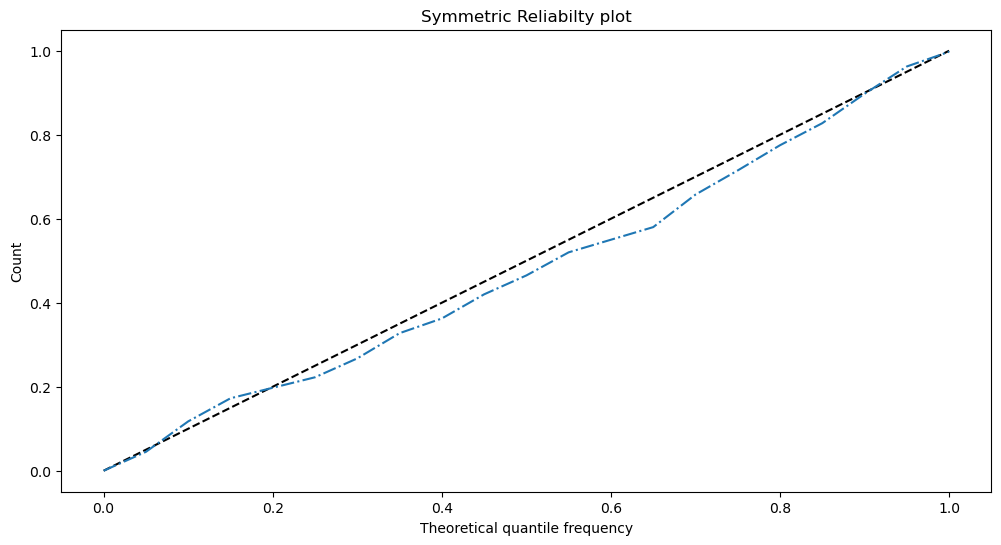

In [25]:
y_hats = []
for idx, x in enumerate(samples_x_test):
    x = torch.from_numpy(x).to(device)
    x = x.unsqueeze(0)
    weights, mu, sigma = model(x)
    weights = weights.flatten().detach().cpu()
    mu = mu.flatten().detach().cpu()
    sigma = sigma.flatten().detach().cpu()

    y_hat = sample_mixture_of_gaussians(weights, mu, sigma, n_samples=1000)
    y_hat = y_hat.numpy()
    y_hats.append(y_hat)

y_hats = np.array(y_hats)
y_hats = y_hats.reshape(y_hats.shape[0], 1, y_hats.shape[1])

fig, ax = uncertainty_plot(samples_y_test, y_hats, title="Assymetric Reliability plot")
plt.show()

fig, ax = uncertainty_plot_centered(samples_y_test, y_hats, title="Symmetric Reliabilty plot")
plt.show()